In [1]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.python.keras import applications
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.layers import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.python.keras.optimizers import RMSprop
import numpy as np
import pandas as pd

In [2]:
#parameters
classes=12
batch_size=16
train_total = 3783
validation_total = 967

In [3]:
model_vgg = VGG16(include_top=False, weights = 'imagenet',input_shape=(224,224,3))

In [4]:
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
x = model_vgg.get_layer('block5_pool').output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(classes, activation='softmax')(x)

In [6]:
model = Model(inputs=model_vgg.input, outputs=x)

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
for layer in model_vgg.layers:
    layer.trainable= False

In [9]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   shear_range = 0.2,
                                   rotation_range = 20,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='reflect',
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_datagen.mean=np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1,1,3)

train_generator = train_datagen.flow_from_directory(
                    'train',
                    target_size=(224,224),
                    batch_size=batch_size,
                    class_mode='categorical',
                    shuffle=True)

Found 3820 images belonging to 12 classes.


In [10]:
validation_datagen = ImageDataGenerator(featurewise_center=True)

validation_datagen.mean=np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1,1,3)

validation_generator = validation_datagen.flow_from_directory(
                        'validation',
                        target_size=(224,224),
                        batch_size=batch_size,
                        class_mode='categorical')

Found 930 images belonging to 12 classes.


In [11]:
model.compile(optimizer=RMSprop(lr=0.00005),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

In [13]:
?CSVLogger

In [13]:
callbacks = [
    ModelCheckpoint(filepath='vgg_fixed_bottom_1.hdf5', verbose=1, save_best_only=True, save_weights_only=True),
    
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1),
    
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),

    CSVLogger('./03-metrics.csv')]

In [16]:
model.fit_generator(train_generator,
                    steps_per_epoch = int(np.ceil(train_total/batch_size)),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps= int(np.ceil(validation_total/batch_size)),
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/50
Epoch 00000: val_loss improved from inf to 3.87908, saving model to vgg_fixed_bottom_1.hdf5
121s - loss: 7.9648 - acc: 0.2532 - val_loss: 3.8791 - val_acc: 0.5353
Epoch 2/50
Epoch 00001: val_loss improved from 3.87908 to 1.90041, saving model to vgg_fixed_bottom_1.hdf5
121s - loss: 5.5453 - acc: 0.4021 - val_loss: 1.9004 - val_acc: 0.6767
Epoch 3/50
Epoch 00002: val_loss improved from 1.90041 to 1.40067, saving model to vgg_fixed_bottom_1.hdf5
101s - loss: 4.2637 - acc: 0.4714 - val_loss: 1.4007 - val_acc: 0.7380
Epoch 4/50
Epoch 00003: val_loss improved from 1.40067 to 1.29968, saving model to vgg_fixed_bottom_1.hdf5
102s - loss: 3.6247 - acc: 0.5214 - val_loss: 1.2997 - val_acc: 0.7609
Epoch 5/50
Epoch 00004: val_loss improved from 1.29968 to 0.85203, saving model to vgg_fixed_bottom_1.hdf5
101s - loss: 2.9718 - acc: 0.5670 - val_loss: 0.8520 - val_acc: 0.7827
Epoch 6/50
Epoch 00005: val_loss did not improve
96s - loss: 2.6392 - acc: 0.5871 - val_loss: 0.9738 - val_acc: 0.

In [14]:
model.load_weights('vgg_fixed_bottom_1.hdf5')

In [15]:
model.compile(optimizer=RMSprop(lr=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.fit_generator(train_generator,
                    steps_per_epoch = int(np.ceil(train_total/batch_size)),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps= int(np.ceil(validation_total/batch_size)),
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/50
Epoch 00000: val_loss improved from inf to 0.55207, saving model to vgg_fixed_bottom_1.hdf5
127s - loss: 1.0715 - acc: 0.7645 - val_loss: 0.5521 - val_acc: 0.8441
Epoch 2/50
Epoch 00001: val_loss did not improve
104s - loss: 0.9551 - acc: 0.7867 - val_loss: 0.5871 - val_acc: 0.8441
Epoch 3/50
Epoch 00002: val_loss improved from 0.55207 to 0.47068, saving model to vgg_fixed_bottom_1.hdf5
101s - loss: 1.0008 - acc: 0.7780 - val_loss: 0.4707 - val_acc: 0.8514
Epoch 4/50
Epoch 00003: val_loss did not improve
96s - loss: 0.9885 - acc: 0.7781 - val_loss: 0.5567 - val_acc: 0.8503
Epoch 5/50
Epoch 00004: val_loss did not improve
97s - loss: 1.0355 - acc: 0.7752 - val_loss: 0.5398 - val_acc: 0.8420
Epoch 6/50
Epoch 00005: val_loss did not improve
96s - loss: 0.9190 - acc: 0.7953 - val_loss: 0.5234 - val_acc: 0.8368
Epoch 7/50
Epoch 00006: val_loss did not improve
96s - loss: 0.9047 - acc: 0.7946 - val_loss: 0.5241 - val_acc: 0.8462
Epoch 8/50
Epoch 00007: val_loss did not improve
97s

In [ ]:
---------------------------------------------------

In [20]:
model.load_weights('vgg_fixed_bottom_1.hdf5')

In [15]:
for layer in model_vgg.layers[15:19]:
    layer.trainable= True

In [17]:
model.compile(optimizer=RMSprop(lr=0.000005),loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
model.fit_generator(train_generator,
                    steps_per_epoch = int(np.ceil(train_total/batch_size)),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps= int(np.ceil(validation_total/batch_size)),
                    verbose=2,
                    callbacks=callbacks)

Epoch 1/50
Epoch 00000: val_loss improved from inf to 0.47812, saving model to vgg_fixed_bottom_1.hdf5
170s - loss: 0.8405 - acc: 0.7840 - val_loss: 0.4781 - val_acc: 0.8430
Epoch 2/50
Epoch 00001: val_loss improved from 0.47812 to 0.43422, saving model to vgg_fixed_bottom_1.hdf5
149s - loss: 0.6486 - acc: 0.8121 - val_loss: 0.4342 - val_acc: 0.8524
Epoch 3/50
Epoch 00002: val_loss improved from 0.43422 to 0.42267, saving model to vgg_fixed_bottom_1.hdf5
136s - loss: 0.6078 - acc: 0.8195 - val_loss: 0.4227 - val_acc: 0.8586
Epoch 4/50
Epoch 00003: val_loss improved from 0.42267 to 0.40938, saving model to vgg_fixed_bottom_1.hdf5
125s - loss: 0.5803 - acc: 0.8317 - val_loss: 0.4094 - val_acc: 0.8514
Epoch 5/50
Epoch 00004: val_loss improved from 0.40938 to 0.38516, saving model to vgg_fixed_bottom_1.hdf5
132s - loss: 0.4910 - acc: 0.8446 - val_loss: 0.3852 - val_acc: 0.8680
Epoch 6/50
Epoch 00005: val_loss improved from 0.38516 to 0.33507, saving model to vgg_fixed_bottom_1.hdf5
130s - 

In [22]:
model.evaluate_generator(validation_generator, int(np.ceil(validation_total/batch_size)))

[0.33473394737528589, 0.9064449064449065]

In [29]:
###############################

In [36]:
tmp = """Epoch 1/50
Epoch 00000: val_loss improved from inf to 3.87908, saving model to vgg_fixed_bottom_1.hdf5
121s - loss: 7.9648 - acc: 0.2532 - val_loss: 3.8791 - val_acc: 0.5353
Epoch 2/50
Epoch 00001: val_loss improved from 3.87908 to 1.90041, saving model to vgg_fixed_bottom_1.hdf5
121s - loss: 5.5453 - acc: 0.4021 - val_loss: 1.9004 - val_acc: 0.6767
Epoch 3/50
Epoch 00002: val_loss improved from 1.90041 to 1.40067, saving model to vgg_fixed_bottom_1.hdf5
101s - loss: 4.2637 - acc: 0.4714 - val_loss: 1.4007 - val_acc: 0.7380
Epoch 4/50
Epoch 00003: val_loss improved from 1.40067 to 1.29968, saving model to vgg_fixed_bottom_1.hdf5
102s - loss: 3.6247 - acc: 0.5214 - val_loss: 1.2997 - val_acc: 0.7609
Epoch 5/50
Epoch 00004: val_loss improved from 1.29968 to 0.85203, saving model to vgg_fixed_bottom_1.hdf5
101s - loss: 2.9718 - acc: 0.5670 - val_loss: 0.8520 - val_acc: 0.7827
Epoch 6/50
Epoch 00005: val_loss did not improve
96s - loss: 2.6392 - acc: 0.5871 - val_loss: 0.9738 - val_acc: 0.7994
Epoch 7/50
Epoch 00006: val_loss did not improve
95s - loss: 2.3316 - acc: 0.6104 - val_loss: 0.8554 - val_acc: 0.8101
Epoch 8/50
Epoch 00007: val_loss did not improve
95s - loss: 2.1501 - acc: 0.6301 - val_loss: 0.9285 - val_acc: 0.7765
Epoch 9/50
Epoch 00008: val_loss improved from 0.85203 to 0.84413, saving model to vgg_fixed_bottom_1.hdf5
102s - loss: 1.9652 - acc: 0.6509 - val_loss: 0.8441 - val_acc: 0.8035
Epoch 10/50
Epoch 00009: val_loss did not improve
95s - loss: 1.8594 - acc: 0.6652 - val_loss: 1.0126 - val_acc: 0.7755
Epoch 11/50
Epoch 00010: val_loss improved from 0.84413 to 0.82736, saving model to vgg_fixed_bottom_1.hdf5
103s - loss: 1.7916 - acc: 0.6712 - val_loss: 0.8274 - val_acc: 0.8015
Epoch 12/50
Epoch 00011: val_loss improved from 0.82736 to 0.67625, saving model to vgg_fixed_bottom_1.hdf5
102s - loss: 1.6178 - acc: 0.6872 - val_loss: 0.6763 - val_acc: 0.8365
Epoch 13/50
Epoch 00012: val_loss did not improve
95s - loss: 1.6647 - acc: 0.6941 - val_loss: 0.8171 - val_acc: 0.8087
Epoch 14/50
Epoch 00013: val_loss improved from 0.67625 to 0.63423, saving model to vgg_fixed_bottom_1.hdf5
105s - loss: 1.5313 - acc: 0.7038 - val_loss: 0.6342 - val_acc: 0.8368
Epoch 15/50
Epoch 00014: val_loss did not improve
97s - loss: 1.4875 - acc: 0.7042 - val_loss: 0.7242 - val_acc: 0.8035
Epoch 16/50
Epoch 00015: val_loss improved from 0.63423 to 0.55729, saving model to vgg_fixed_bottom_1.hdf5
103s - loss: 1.4936 - acc: 0.7124 - val_loss: 0.5573 - val_acc: 0.8503
Epoch 17/50
Epoch 00016: val_loss did not improve
95s - loss: 1.3783 - acc: 0.7284 - val_loss: 0.6697 - val_acc: 0.8139
Epoch 18/50
Epoch 00017: val_loss did not improve
98s - loss: 1.2834 - acc: 0.7456 - val_loss: 0.5941 - val_acc: 0.8514
Epoch 19/50
Epoch 00018: val_loss did not improve
95s - loss: 1.2721 - acc: 0.7364 - val_loss: 0.6879 - val_acc: 0.8087
Epoch 20/50
Epoch 00019: val_loss did not improve
95s - loss: 1.1929 - acc: 0.7460 - val_loss: 0.6650 - val_acc: 0.8472
Epoch 21/50
Epoch 00020: val_loss improved from 0.55729 to 0.55076, saving model to vgg_fixed_bottom_1.hdf5
102s - loss: 1.3463 - acc: 0.7352 - val_loss: 0.5508 - val_acc: 0.8586
Epoch 22/50
Epoch 00021: val_loss improved from 0.55076 to 0.47223, saving model to vgg_fixed_bottom_1.hdf5
102s - loss: 1.2294 - acc: 0.7419 - val_loss: 0.4722 - val_acc: 0.8472
Epoch 23/50
Epoch 00022: val_loss did not improve
96s - loss: 1.1331 - acc: 0.7620 - val_loss: 0.6118 - val_acc: 0.8378
Epoch 24/50
Epoch 00023: val_loss did not improve
95s - loss: 1.1053 - acc: 0.7691 - val_loss: 0.6812 - val_acc: 0.8306
Epoch 25/50
Epoch 00024: val_loss did not improve
95s - loss: 1.1714 - acc: 0.7657 - val_loss: 0.6799 - val_acc: 0.8285
Epoch 26/50
Epoch 00025: val_loss did not improve
94s - loss: 1.1162 - acc: 0.7629 - val_loss: 0.7115 - val_acc: 0.8243
Epoch 27/50
Epoch 00026: val_loss did not improve
95s - loss: 1.1463 - acc: 0.7602 - val_loss: 0.7709 - val_acc: 0.8306
Epoch 28/50
Epoch 00027: val_loss did not improve
Epoch 00027: reducing learning rate to 4.999999873689376e-06.
95s - loss: 1.0704 - acc: 0.7726 - val_loss: 0.5712 - val_acc: 0.8254
Epoch 29/50
Epoch 00028: val_loss did not improve
98s - loss: 1.0248 - acc: 0.7770 - val_loss: 0.5645 - val_acc: 0.8368
Epoch 30/50
Epoch 00029: val_loss did not improve
95s - loss: 0.9526 - acc: 0.7947 - val_loss: 0.6136 - val_acc: 0.8295
Epoch 31/50
Epoch 00030: val_loss did not improve
95s - loss: 0.9632 - acc: 0.7854 - val_loss: 0.5192 - val_acc: 0.8410
Epoch 32/50
Epoch 00031: val_loss did not improve
95s - loss: 0.9249 - acc: 0.7997 - val_loss: 0.5037 - val_acc: 0.8399
Epoch 33/50
Epoch 00032: val_loss did not improve
Epoch 00032: reducing learning rate to 4.999999873689376e-07.
95s - loss: 0.8696 - acc: 0.8003 - val_loss: 0.5433 - val_acc: 0.8181
Epoch 1/50
Epoch 00000: val_loss improved from inf to 0.55207, saving model to vgg_fixed_bottom_1.hdf5
127s - loss: 1.0715 - acc: 0.7645 - val_loss: 0.5521 - val_acc: 0.8441
Epoch 2/50
Epoch 00001: val_loss did not improve
104s - loss: 0.9551 - acc: 0.7867 - val_loss: 0.5871 - val_acc: 0.8441
Epoch 3/50
Epoch 00002: val_loss improved from 0.55207 to 0.47068, saving model to vgg_fixed_bottom_1.hdf5
101s - loss: 1.0008 - acc: 0.7780 - val_loss: 0.4707 - val_acc: 0.8514
Epoch 4/50
Epoch 00003: val_loss did not improve
96s - loss: 0.9885 - acc: 0.7781 - val_loss: 0.5567 - val_acc: 0.8503
Epoch 5/50
Epoch 00004: val_loss did not improve
97s - loss: 1.0355 - acc: 0.7752 - val_loss: 0.5398 - val_acc: 0.8420
Epoch 6/50
Epoch 00005: val_loss did not improve
96s - loss: 0.9190 - acc: 0.7953 - val_loss: 0.5234 - val_acc: 0.8368
Epoch 7/50
Epoch 00006: val_loss did not improve
96s - loss: 0.9047 - acc: 0.7946 - val_loss: 0.5241 - val_acc: 0.8462
Epoch 8/50
Epoch 00007: val_loss did not improve
97s - loss: 0.9725 - acc: 0.7827 - val_loss: 0.5323 - val_acc: 0.8430
Epoch 9/50
Epoch 00008: val_loss did not improve
Epoch 00008: reducing learning rate to 4.999999873689376e-07.
98s - loss: 0.8498 - acc: 0.7971 - val_loss: 0.4942 - val_acc: 0.8472
Epoch 10/50
Epoch 00009: val_loss did not improve
97s - loss: 0.9140 - acc: 0.7866 - val_loss: 0.5633 - val_acc: 0.8430
Epoch 11/50
Epoch 00010: val_loss did not improve
95s - loss: 0.8859 - acc: 0.7888 - val_loss: 0.5278 - val_acc: 0.8472
Epoch 12/50
Epoch 00011: val_loss did not improve
104s - loss: 0.8612 - acc: 0.7972 - val_loss: 0.5085 - val_acc: 0.8482
Epoch 13/50
Epoch 00012: val_loss did not improve
113s - loss: 0.8742 - acc: 0.7959 - val_loss: 0.5664 - val_acc: 0.8451
Epoch 14/50
Epoch 00013: val_loss did not improve
Epoch 00013: reducing learning rate to 4.999999987376214e-08.
114s - loss: 0.9078 - acc: 0.7814 - val_loss: 0.5204 - val_acc: 0.8493
Epoch 1/50
Epoch 00000: val_loss improved from inf to 0.47812, saving model to vgg_fixed_bottom_1.hdf5
170s - loss: 0.8405 - acc: 0.7840 - val_loss: 0.4781 - val_acc: 0.8430
Epoch 2/50
Epoch 00001: val_loss improved from 0.47812 to 0.43422, saving model to vgg_fixed_bottom_1.hdf5
149s - loss: 0.6486 - acc: 0.8121 - val_loss: 0.4342 - val_acc: 0.8524
Epoch 3/50
Epoch 00002: val_loss improved from 0.43422 to 0.42267, saving model to vgg_fixed_bottom_1.hdf5
136s - loss: 0.6078 - acc: 0.8195 - val_loss: 0.4227 - val_acc: 0.8586
Epoch 4/50
Epoch 00003: val_loss improved from 0.42267 to 0.40938, saving model to vgg_fixed_bottom_1.hdf5
125s - loss: 0.5803 - acc: 0.8317 - val_loss: 0.4094 - val_acc: 0.8514
Epoch 5/50
Epoch 00004: val_loss improved from 0.40938 to 0.38516, saving model to vgg_fixed_bottom_1.hdf5
132s - loss: 0.4910 - acc: 0.8446 - val_loss: 0.3852 - val_acc: 0.8680
Epoch 6/50
Epoch 00005: val_loss improved from 0.38516 to 0.33507, saving model to vgg_fixed_bottom_1.hdf5
130s - loss: 0.4908 - acc: 0.8499 - val_loss: 0.3351 - val_acc: 0.8825
Epoch 7/50
Epoch 00006: val_loss did not improve
116s - loss: 0.4388 - acc: 0.8600 - val_loss: 0.4011 - val_acc: 0.8742
Epoch 8/50
Epoch 00007: val_loss did not improve
114s - loss: 0.4371 - acc: 0.8622 - val_loss: 0.3700 - val_acc: 0.8628
Epoch 9/50
Epoch 00008: val_loss did not improve
111s - loss: 0.4169 - acc: 0.8680 - val_loss: 0.3563 - val_acc: 0.8753
Epoch 10/50
Epoch 00009: val_loss did not improve
114s - loss: 0.4074 - acc: 0.8694 - val_loss: 0.4179 - val_acc: 0.8721
Epoch 11/50
Epoch 00010: val_loss improved from 0.33507 to 0.33410, saving model to vgg_fixed_bottom_1.hdf5
118s - loss: 0.3993 - acc: 0.8686 - val_loss: 0.3341 - val_acc: 0.8836
Epoch 12/50
Epoch 00011: val_loss did not improve
115s - loss: 0.3946 - acc: 0.8729 - val_loss: 0.3570 - val_acc: 0.8877
Epoch 13/50
Epoch 00012: val_loss improved from 0.33410 to 0.32900, saving model to vgg_fixed_bottom_1.hdf5
119s - loss: 0.3896 - acc: 0.8741 - val_loss: 0.3290 - val_acc: 0.8867
Epoch 14/50
Epoch 00013: val_loss did not improve
113s - loss: 0.3745 - acc: 0.8805 - val_loss: 0.3336 - val_acc: 0.9012
Epoch 15/50
Epoch 00014: val_loss did not improve
111s - loss: 0.3816 - acc: 0.8726 - val_loss: 0.3489 - val_acc: 0.8815
Epoch 16/50
Epoch 00015: val_loss did not improve
112s - loss: 0.3395 - acc: 0.8884 - val_loss: 0.3335 - val_acc: 0.8960
Epoch 17/50
Epoch 00016: val_loss improved from 0.32900 to 0.29936, saving model to vgg_fixed_bottom_1.hdf5
118s - loss: 0.3514 - acc: 0.8900 - val_loss: 0.2994 - val_acc: 0.8992
Epoch 18/50
Epoch 00017: val_loss did not improve
114s - loss: 0.3367 - acc: 0.8918 - val_loss: 0.3151 - val_acc: 0.8992
Epoch 19/50
Epoch 00018: val_loss did not improve
111s - loss: 0.3284 - acc: 0.8930 - val_loss: 0.3418 - val_acc: 0.8825
Epoch 20/50
Epoch 00019: val_loss improved from 0.29936 to 0.29294, saving model to vgg_fixed_bottom_1.hdf5
121s - loss: 0.3402 - acc: 0.8895 - val_loss: 0.2929 - val_acc: 0.9044
Epoch 21/50
Epoch 00020: val_loss did not improve
117s - loss: 0.3009 - acc: 0.9000 - val_loss: 0.3299 - val_acc: 0.9002
Epoch 22/50
Epoch 00021: val_loss did not improve
112s - loss: 0.3167 - acc: 0.8984 - val_loss: 0.3181 - val_acc: 0.9054
Epoch 23/50
Epoch 00022: val_loss did not improve
115s - loss: 0.3259 - acc: 0.9001 - val_loss: 0.3016 - val_acc: 0.9054
Epoch 24/50
Epoch 00023: val_loss did not improve
111s - loss: 0.3111 - acc: 0.8973 - val_loss: 0.3425 - val_acc: 0.9023
Epoch 25/50
Epoch 00024: val_loss did not improve
111s - loss: 0.2776 - acc: 0.9114 - val_loss: 0.3089 - val_acc: 0.8950
Epoch 26/50
Epoch 00025: val_loss did not improve
Epoch 00025: reducing learning rate to 4.999999873689376e-07.
114s - loss: 0.3014 - acc: 0.9023 - val_loss: 0.3002 - val_acc: 0.9064
Epoch 27/50
Epoch 00026: val_loss improved from 0.29294 to 0.28777, saving model to vgg_fixed_bottom_1.hdf5
120s - loss: 0.2835 - acc: 0.9088 - val_loss: 0.2878 - val_acc: 0.9116
Epoch 28/50
Epoch 00027: val_loss did not improve
115s - loss: 0.2898 - acc: 0.9012 - val_loss: 0.3776 - val_acc: 0.9012
Epoch 29/50
Epoch 00028: val_loss did not improve
114s - loss: 0.2703 - acc: 0.9122 - val_loss: 0.2951 - val_acc: 0.9137
Epoch 30/50
Epoch 00029: val_loss did not improve
110s - loss: 0.2516 - acc: 0.9154 - val_loss: 0.3325 - val_acc: 0.9012
Epoch 31/50
Epoch 00030: val_loss did not improve
117s - loss: 0.2607 - acc: 0.9196 - val_loss: 0.2958 - val_acc: 0.9127
Epoch 32/50
Epoch 00031: val_loss did not improve
111s - loss: 0.2686 - acc: 0.9104 - val_loss: 0.3097 - val_acc: 0.9085
Epoch 33/50
Epoch 00032: val_loss did not improve
Epoch 00032: reducing learning rate to 4.999999987376214e-08.
112s - loss: 0.2354 - acc: 0.9217 - val_loss: 0.3253 - val_acc: 0.9085
Epoch 34/50
Epoch 00033: val_loss did not improve
115s - loss: 0.2658 - acc: 0.9131 - val_loss: 0.3150 - val_acc: 0.9054
Epoch 35/50
Epoch 00034: val_loss did not improve
114s - loss: 0.2640 - acc: 0.9097 - val_loss: 0.3030 - val_acc: 0.9127
Epoch 36/50
Epoch 00035: val_loss did not improve
111s - loss: 0.2856 - acc: 0.9133 - val_loss: 0.3291 - val_acc: 0.9002
Epoch 37/50
Epoch 00036: val_loss improved from 0.28777 to 0.27527, saving model to vgg_fixed_bottom_1.hdf5
116s - loss: 0.2774 - acc: 0.9061 - val_loss: 0.2753 - val_acc: 0.9179
Epoch 38/50
Epoch 00037: val_loss did not improve
111s - loss: 0.2772 - acc: 0.9108 - val_loss: 0.3369 - val_acc: 0.8981
Epoch 39/50
Epoch 00038: val_loss did not improve
114s - loss: 0.2666 - acc: 0.9101 - val_loss: 0.2928 - val_acc: 0.9106
Epoch 40/50
Epoch 00039: val_loss did not improve
111s - loss: 0.2636 - acc: 0.9212 - val_loss: 0.3457 - val_acc: 0.9054
Epoch 41/50
Epoch 00040: val_loss did not improve
110s - loss: 0.2512 - acc: 0.9138 - val_loss: 0.3174 - val_acc: 0.9044
Epoch 42/50
Epoch 00041: val_loss did not improve
118s - loss: 0.2479 - acc: 0.9172 - val_loss: 0.3102 - val_acc: 0.9075
Epoch 43/50
Epoch 00042: val_loss did not improve
Epoch 00042: reducing learning rate to 5.000000058430488e-09.
114s - loss: 0.2658 - acc: 0.9114 - val_loss: 0.3211 - val_acc: 0.9116
Epoch 44/50
Epoch 00043: val_loss did not improve
112s - loss: 0.2672 - acc: 0.9153 - val_loss: 0.3167 - val_acc: 0.9023
Epoch 45/50
Epoch 00044: val_loss did not improve
111s - loss: 0.2754 - acc: 0.9081 - val_loss: 0.2818 - val_acc: 0.9200
Epoch 46/50
Epoch 00045: val_loss did not improve
113s - loss: 0.2510 - acc: 0.9175 - val_loss: 0.3254 - val_acc: 0.9106
Epoch 47/50
Epoch 00046: val_loss did not improve
112s - loss: 0.2672 - acc: 0.9161 - val_loss: 0.3103 - val_acc: 0.9012
Epoch 48/50
Epoch 00047: val_loss did not improve
Epoch 00047: reducing learning rate to 4.999999969612646e-10.
112s - loss: 0.2636 - acc: 0.9142 - val_loss: 0.3091 - val_acc: 0.9096
"""

In [37]:
tmp = tmp.splitlines()
tmp

['Epoch 1/50',
 'Epoch 00000: val_loss improved from inf to 3.87908, saving model to vgg_fixed_bottom_1.hdf5',
 '121s - loss: 7.9648 - acc: 0.2532 - val_loss: 3.8791 - val_acc: 0.5353',
 'Epoch 2/50',
 'Epoch 00001: val_loss improved from 3.87908 to 1.90041, saving model to vgg_fixed_bottom_1.hdf5',
 '121s - loss: 5.5453 - acc: 0.4021 - val_loss: 1.9004 - val_acc: 0.6767',
 'Epoch 3/50',
 'Epoch 00002: val_loss improved from 1.90041 to 1.40067, saving model to vgg_fixed_bottom_1.hdf5',
 '101s - loss: 4.2637 - acc: 0.4714 - val_loss: 1.4007 - val_acc: 0.7380',
 'Epoch 4/50',
 'Epoch 00003: val_loss improved from 1.40067 to 1.29968, saving model to vgg_fixed_bottom_1.hdf5',
 '102s - loss: 3.6247 - acc: 0.5214 - val_loss: 1.2997 - val_acc: 0.7609',
 'Epoch 5/50',
 'Epoch 00004: val_loss improved from 1.29968 to 0.85203, saving model to vgg_fixed_bottom_1.hdf5',
 '101s - loss: 2.9718 - acc: 0.5670 - val_loss: 0.8520 - val_acc: 0.7827',
 'Epoch 6/50',
 'Epoch 00005: val_loss did not improve

In [38]:
tmp = [x for x in tmp if x[0] != 'E']
tmp

['121s - loss: 7.9648 - acc: 0.2532 - val_loss: 3.8791 - val_acc: 0.5353',
 '121s - loss: 5.5453 - acc: 0.4021 - val_loss: 1.9004 - val_acc: 0.6767',
 '101s - loss: 4.2637 - acc: 0.4714 - val_loss: 1.4007 - val_acc: 0.7380',
 '102s - loss: 3.6247 - acc: 0.5214 - val_loss: 1.2997 - val_acc: 0.7609',
 '101s - loss: 2.9718 - acc: 0.5670 - val_loss: 0.8520 - val_acc: 0.7827',
 '96s - loss: 2.6392 - acc: 0.5871 - val_loss: 0.9738 - val_acc: 0.7994',
 '95s - loss: 2.3316 - acc: 0.6104 - val_loss: 0.8554 - val_acc: 0.8101',
 '95s - loss: 2.1501 - acc: 0.6301 - val_loss: 0.9285 - val_acc: 0.7765',
 '102s - loss: 1.9652 - acc: 0.6509 - val_loss: 0.8441 - val_acc: 0.8035',
 '95s - loss: 1.8594 - acc: 0.6652 - val_loss: 1.0126 - val_acc: 0.7755',
 '103s - loss: 1.7916 - acc: 0.6712 - val_loss: 0.8274 - val_acc: 0.8015',
 '102s - loss: 1.6178 - acc: 0.6872 - val_loss: 0.6763 - val_acc: 0.8365',
 '95s - loss: 1.6647 - acc: 0.6941 - val_loss: 0.8171 - val_acc: 0.8087',
 '105s - loss: 1.5313 - acc: 0

In [39]:
import re
train_loss = [float(re.search('loss: ([0-9\.]+)', x).group(1)) for x in tmp]
train_acc  = [float(re.search('acc: ([0-9\.]+)', x).group(1)) for x in tmp]
val_loss   = [float(re.search('val_loss: ([0-9\.]+)', x).group(1)) for x in tmp]
val_acc    = [float(re.search('val_acc: ([0-9\.]+)', x).group(1)) for x in tmp]

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
len(train_loss)

95

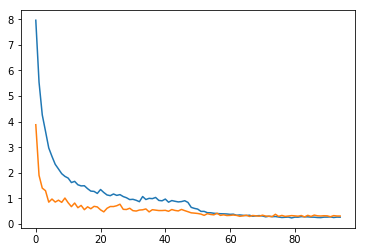

In [43]:
plt.plot(range(len(train_loss)), train_loss,
         range(len(train_loss)), val_loss);

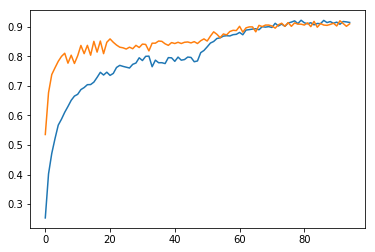

In [44]:
plt.plot(range(len(train_loss)), train_acc,
         range(len(train_loss)), val_acc);

In [27]:
test_datagen = ImageDataGenerator(featurewise_center=True)

test_datagen.mean=np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1,1,3)

test_generator = test_datagen.flow_from_directory(
                        'test',
                        target_size=(224,224),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=False)

Found 794 images belonging to 1 classes.


In [28]:
predictions = model.predict_generator(test_generator,int(np.ceil(794/batch_size)))
class_ids = {train_generator.class_indices[x]: x for x in train_generator.class_indices}
predicted_classes = [class_ids[x] for x in np.argmax(predictions, axis=1)]

In [29]:
from os.path import basename
test_ids = [basename(x) for x in test_generator.filenames]
submission = pd.DataFrame({'file':test_ids,'species':predicted_classes})
submission.to_csv('submission_vgg_16.csv', encoding="utf8", index=False)

In [30]:
from IPython.display import FileLink
FileLink('submission_vgg_16.csv')

/home/janardhan/plant_seeding/submission_vgg_16.csv

In [ ]:
# PB LB: 0.93073